In [1]:
%pylab inline
import numpy as np
import yaml
from scipy.interpolate import interp1d
from scipy.optimize import leastsq

Populating the interactive namespace from numpy and matplotlib


In [12]:

def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

def lag_calc(yy,yy_shifted):
    #easy way, with max res of 1 unit of time
    #returns positive value for lag (i.e., yy_shifted occurs after yy in time)
    from scipy import signal
    
    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag*-1

In [13]:
#load the yaml data, assign block presentation data and device response data
data = load_yaml('./testing/Isa3_Test_Right_Only_out-file.txt')
blocks = data['blocks']
device_idx = 0
for_resp = data['devices'][device_idx]

In [27]:

# input data 1st block 1st trial (left): blocks[0]['trials'][0]['leftReference']
#       times,values
#block start time @ startTimestamp, end @ endTimestamp

## loop over each block
block_idx = 0
## loop over each trial
trial_idx = 2
MVC = data['maximumLeftVoluntaryContraction']
ref_time = np.array(blocks[block_idx]['trials'][trial_idx]['leftReference']['times'])
ref_vals = np.array(blocks[block_idx]['trials'][trial_idx]['leftReference']['values'])

#all times from the device over the course of the experiment

for_time_all = np.array(for_resp['times'])
for_vals_all = compute_normalized_force_response(np.array(for_resp['values']),MVC)

#loop this to identify the start and end times of the trials
start = ref_time[0]
end = ref_time[-1]

# compute mask of data in for response vector associated with this specific trial, select time/vals
for_trial_mask = (for_time_all-start >= 0) & (for_time_all-end<=0) 
for_time = for_time_all[for_trial_mask]
for_vals = for_vals_all[for_trial_mask]

ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly
trial_lag_xcorr = lag_calc(ref_vals_interp,for_vals) #in samples
time_per_interval = np.median(np.diff(for_time)) #time, in ms
time_std_per_interval = np.std(np.diff(for_time)) #time, in ms
trial_lag_xcorr_ms = trial_lag_xcorr*time_per_interval

#but first we should do the crosscorr
trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
trial_sse = ((ref_vals_interp-for_vals)**2).sum()

lag_aligned_trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
lag_aligned_trial_sse = ((ref_vals_interp-for_vals)**2).sum()

## we now take the aligned vectors, snip the parts that we do not have data for, and compare
if trial_lag_xcorr >=0: #we have a lag (i.e., the force comes after the reference)
    snipped_for_vals = for_vals[trial_lag_xcorr:]
    snipped_ref_vals = ref_vals_interp[0:trial_lag_xcorr*-1]
elif trial_lag_xcorr <0: #force preceded the reference
    snipped_for_vals = for_vals[0:trial_lag_xcorr*-1]
    snipped_ref_vals = ref_vals_interp[trial_lag_xcorr:]

lag_aligned_trial_rmse = np.sqrt(np.mean((snipped_ref_vals-snipped_for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
lag_aligned_trial_sse = ((snipped_ref_vals-snipped_for_vals)**2).sum()

print(time_per_interval)
print(time_std_per_interval)
print(trial_lag_xcorr)
print(trial_lag_xcorr_ms)
print(trial_rmse)
print(trial_sse)
print(lag_aligned_trial_rmse)
print(lag_aligned_trial_sse)


11.930000066757202
0.6478843228042159
6
71.58000040054321
0.19874968747602836
79.04237798190972
0.1947460870721924
75.66244666771023


In [23]:
end-start

23578.670000076294

(1995,)
(1995,)


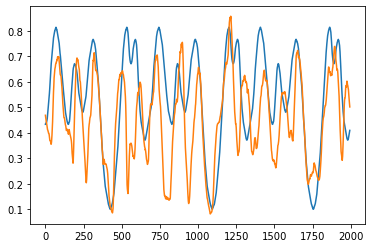

In [18]:


print(snipped_for_vals.shape)
print(snipped_ref_vals.shape)

plt.plot(snipped_ref_vals)
plt.plot(snipped_for_vals)
# for_vals.shape

[0]
[0.]
[0.]
[1.49011612e-08]
0.0
-6


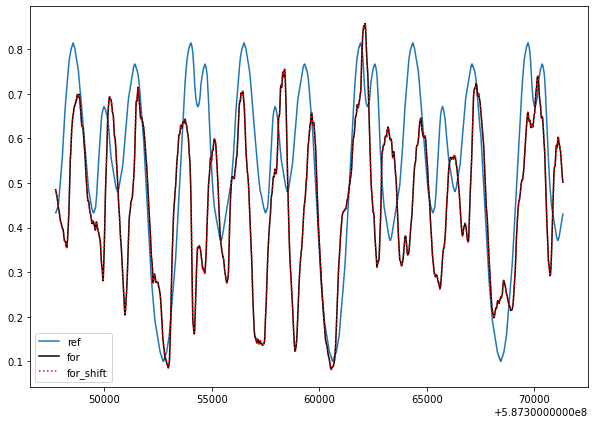

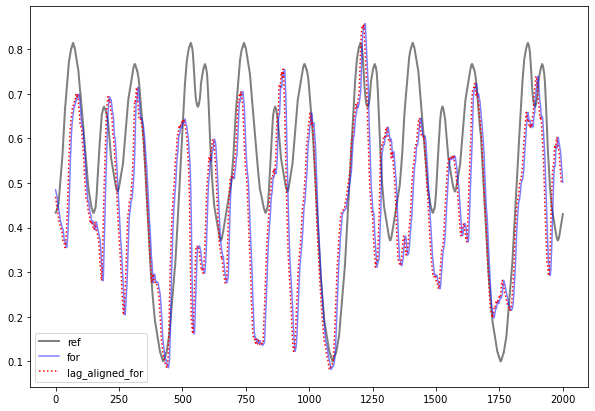

In [75]:
#bring the reference positions into the same time space as the force for direct comparison (linear interp)
# ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

# # compute temporal lag
def err_func(p):
    print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
lag_xcorr = lag_calc(ref_vals_interp,for_vals)
print(found_shift)
print(lag_xcorr)

# # lstsq approach
# plt.figure(figsize=(10,7))
# # plt.plot(ref_time,ref_vals,'.',label='ref_orig')
# plt.plot(for_time,ref_vals_interp,label='ref')
# plt.plot(for_time,for_vals,'k-',label='for')
# plt.plot(for_time+found_shift,for_vals,'r:',label='for_shift')
# plt.legend()

plt.figure(figsize=(10,7)) #xcorr approach
plt.plot(ref_vals_interp,'k-',linewidth=2,label='ref',alpha=0.5)
plt.plot(for_vals,'b-',label='for',alpha=0.5)
plt.plot(for_vals[lag_xcorr*-1:],'r:',label='lag_aligned_for')
plt.legend()